# Face Generation

In this project, I'll define and train a DCGAN on a dataset of faces. ourgoal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, I'll be able to visualize the results of ourtrained Generator to see how it performs; ourgenerated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

I'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train ouradversarial networks.

### Pre-processed Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />


This is a zip file that weexract in the home directory of this notebook for further loading and processing.

In [25]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since we are going to be generating faces, we won't need the annotations, we'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that I'll need to **transform** this data and create a **DataLoader**.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that we use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [5]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    #  Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()])
    
    image_path = './' + data_dir
    
    dataset = datasets.ImageFolder(image_path, transform)
    
    data_loader = DataLoader(dataset, batch_size, shuffle=True)
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* we can decide on any reasonable `batch_size` parameter
* our `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [6]:
# Define function hyperparameters
batch_size = 16
img_size = 32

# Call our function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, we can view some images! we should seen square images of somewhat-centered faces.

Note: we'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

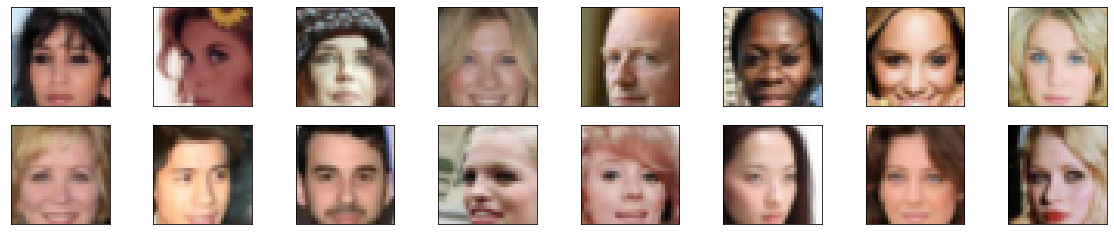

In [9]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process our image data and scale it to a pixel range of -1 to 1

we need to do a bit of pre-processing; we know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [10]:
#  Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_x, max_x = torch.min(x), torch.max(x)
    new_min, new_max = feature_range
    
    x = (new_max-new_min) * (x - min_x)/(max_x - min_x) + new_min
    
    return x


In [11]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

our first task will be to define the discriminator. This is a convolutional classifier like we've built before, only without any maxpooling layers. To deal with this complex data, it's suggested we use a deep network with **normalization**. we are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1,
        batch_norm=True):
    """
        Create a convolution layer, 
        with optional batch normalization on output of convolution layer 
    """
    layers=[]
    
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    
    return nn.Sequential(*layers)
    

In [14]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1,
        batch_norm=True):
    """
        Create a convolution layer, 
        with optional batch normalization on output of convolution layer 
    """
    layers=[]
    
    conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    
    return nn.Sequential(*layers)

In [15]:
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels
images.shape

torch.Size([16, 3, 32, 32])

In [16]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=64):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim
        
        # complete init function
        # In: 32*32*3
        self.conv1 = conv(3, conv_dim, kernel_size=4, batch_norm=False)
        # Out: 16*16*conv_dim
        self.conv2 = conv(conv_dim, conv_dim*2, kernel_size=4)
        # Out: 8*8*conv_dim*2
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size=4)
        # Out: 4*4*conv_dim*4
        
        # FC layer
        self.fc = nn.Linear(4*4*conv_dim*4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        
        # Flatten x
        x = x.view(-1, 4*4*self.conv_dim*4)
        
        # Pass to FC layer and return only logit of x
        # NO activation applied on x
        x = self.fc(x)
        
        return x




## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [17]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=64):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        self.conv_dim = conv_dim
        
        # complete init function
        # First FC layer to scale z_size into size of last FC 
        self.fc = nn.Linear(z_size, 4*4*conv_dim*4)
        
        # deconv layers
        # 4*4*64*4
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, kernel_size=4)
        # 8*8*64*2
        self.deconv2 = deconv(conv_dim*2, conv_dim, kernel_size=4)
        # 16*16*64
        self.deconv3 = deconv(conv_dim, 3, kernel_size=4, batch_norm=False)
        # 32*32*3
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        
        # resize x
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        # deconv layers
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        
        # Last layer
        x = F.tanh(self.deconv3(x))
        
        
        return x

    


## Initialize the weights of our networks

To help our models converge, we should initialize the weights of the convolutional and linear layers in our model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, our next task will be to define a weight initialization function that does just this!

we can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help we complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [18]:
from torch.nn import init

In [19]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    #  Apply initial weights to convolutional and linear layers
    if (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
    

## Build complete network

Define our models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure we've passed in the correct input arguments.

In [20]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Define model hyperparameters

In [21]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

### Training on GPU

Check if we can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, we'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [22]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train our neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train our neural network.


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**we may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [23]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size()[0]
    
    labels = torch.ones(batch_size)
    
    # labels smoothing
    if (smooth):
        labels = labels * 0.9
        
    if (train_on_gpu):
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size()[0]
    
    labels = torch.zeros(batch_size)
    
    if (train_on_gpu):
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss


## Optimizers

#### Exercise: Define optimizers for our Discriminator (D) and Generator (G)

Define optimizers for our models with appropriate hyperparameters.

In [24]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, (beta1,beta2))
g_optimizer = optim.Adam(G.parameters(), lr, (beta1,beta2))

---
## Training

Training will involve alternating between training the discriminator and the generator. we'll use our functions `real_loss` and `fake_loss` to help we calculate the discriminator losses.

* we should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

we've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if we've moved our models to GPU, we'll also have to move any model inputs to GPU.

In [56]:
def train(D, G, n_epochs, print_every=300):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         our CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            if (train_on_gpu):
                real_images = real_images.cuda()
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            # Loss of Discriminator on real images
            D_loss_real = real_loss(D(real_images), smooth=True)
            
            # Loss of Discriminator on fake images
            # 1. Generate fake images
            z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            z = torch.from_numpy(z).float()
            if (train_on_gpu):
                z = z.cuda()
            fake_images = G(z)
            
            # 2. Get D loss on fake images
            D_loss_fake = fake_loss(D(fake_images))

            
            d_loss = D_loss_real + D_loss_fake
            d_loss.backward()
            d_optimizer.step()
            

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(sample_size, z_size))
            z = torch.from_numpy(z).float()
            if (train_on_gpu):
                z = z.cuda()
            fake_images = G(z)
            
            g_loss = real_loss(D(fake_images), smooth=False)
            g_loss.backward()
            g_optimizer.step()
        
            
            
            # ===============================================
            #              END OF our CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes our generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set our number of training epochs and train our GAN!

In [57]:
# set number of epochs 
n_epochs = 20


# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.1973 | g_loss: 1.5412
Epoch [    1/   20] | d_loss: 0.9309 | g_loss: 2.6893
Epoch [    1/   20] | d_loss: 0.7481 | g_loss: 1.7133
Epoch [    1/   20] | d_loss: 0.9698 | g_loss: 2.2719
Epoch [    1/   20] | d_loss: 1.2724 | g_loss: 2.5364
Epoch [    1/   20] | d_loss: 0.8782 | g_loss: 2.2356
Epoch [    1/   20] | d_loss: 1.1136 | g_loss: 1.1802
Epoch [    1/   20] | d_loss: 0.9791 | g_loss: 2.1127
Epoch [    1/   20] | d_loss: 1.1181 | g_loss: 1.3608
Epoch [    1/   20] | d_loss: 0.9309 | g_loss: 1.6669
Epoch [    1/   20] | d_loss: 1.0536 | g_loss: 1.4659
Epoch [    1/   20] | d_loss: 1.0030 | g_loss: 1.4577
Epoch [    2/   20] | d_loss: 1.0713 | g_loss: 1.8892
Epoch [    2/   20] | d_loss: 1.0941 | g_loss: 1.5928
Epoch [    2/   20] | d_loss: 1.4616 | g_loss: 1.1762
Epoch [    2/   20] | d_loss: 1.0832 | g_loss: 1.3161
Epoch [    2/   20] | d_loss: 0.9640 | g_loss: 1.4345
Epoch [    2/   20] | d_loss: 0.7523 | g_loss: 1.7009
Epoch [    2/   20] | d_loss

Epoch [   13/   20] | d_loss: 0.4284 | g_loss: 2.4896
Epoch [   13/   20] | d_loss: 0.5192 | g_loss: 2.7529
Epoch [   13/   20] | d_loss: 0.6745 | g_loss: 2.9793
Epoch [   13/   20] | d_loss: 0.6049 | g_loss: 1.7667
Epoch [   14/   20] | d_loss: 0.6543 | g_loss: 2.6085
Epoch [   14/   20] | d_loss: 0.7809 | g_loss: 2.5051
Epoch [   14/   20] | d_loss: 0.5422 | g_loss: 3.9541
Epoch [   14/   20] | d_loss: 0.5440 | g_loss: 3.5217
Epoch [   14/   20] | d_loss: 0.6019 | g_loss: 1.4346
Epoch [   14/   20] | d_loss: 0.5382 | g_loss: 3.0621
Epoch [   14/   20] | d_loss: 0.6249 | g_loss: 1.9400
Epoch [   14/   20] | d_loss: 0.8081 | g_loss: 1.9035
Epoch [   14/   20] | d_loss: 0.6448 | g_loss: 2.6325
Epoch [   14/   20] | d_loss: 0.5129 | g_loss: 2.3502
Epoch [   14/   20] | d_loss: 0.8552 | g_loss: 2.3501
Epoch [   14/   20] | d_loss: 0.4405 | g_loss: 1.9570
Epoch [   15/   20] | d_loss: 0.5825 | g_loss: 2.8917
Epoch [   15/   20] | d_loss: 0.5489 | g_loss: 4.1603
Epoch [   15/   20] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

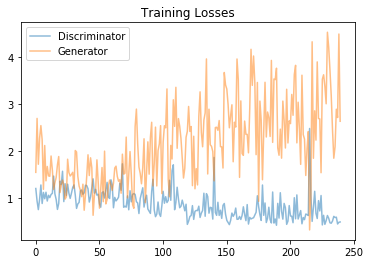

In [58]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of our trained models.

In [59]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3))) 

In [60]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

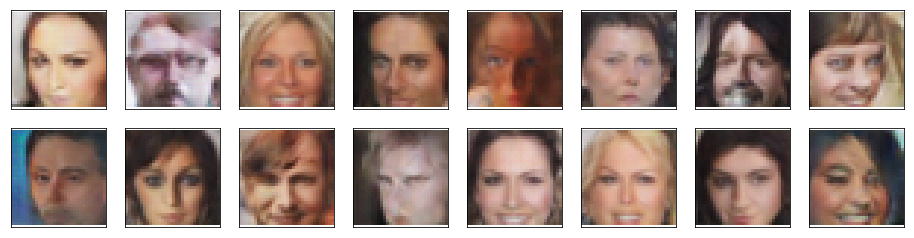

In [61]:
_ = view_samples(-1, samples)

### What do we notice about our generated samples and how might we improve this model?


1. The people have "white" face generally, hence we know the original data does not have a lots of "black" celebrities --> In order to improve the GAN generated outputs, we should collect more faces of black celebrities

2. Increase the size of original images from 32x32 to 256x256 and build larger model to generate more sharp images

3. Parameters for optimizers are selected follow DCGAN original paper, hence I would like to keep them as they were. For number of epochs, I only train with 20 epochs, hence if I train the model on more epochs like 50 epochs then I believe the model will generate better results 